In [ ]:
import pickle
import numpy as np
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys, os
sys.path.append(os.path.abspath("/Users/ananyaparikh/Documents/Coding/DeepRGARCH/DeepRGARCH"))
from rerech import utils as ut
from rerech import utils as ut
from rerech import model as mdl
import distributions as dists
import pickle
from collections import defaultdict
from smc import ThetaParticles


# 1) load the pickle of all your rv/return data
raw = ut.load_rv('/Users/ananyaparikh/Documents/Coding/DeepRGARCH/code submission/data/rv.pkl')

# 2) build the dict structure you’ve been using elsewhere
data_dict = ut.build_data_dict(raw)

# 3) pick one of your tickers (e.g. SPX) and take its test-period returns
r = data_dict['SPX']['test']['y_test']

In [ ]:

def safe_sigmoid(x):
    """Numerically stable sigmoid function"""
    # Clip extreme values to prevent overflow
    x_safe = np.clip(x, -50.0, 50.0)
    return 1.0 / (1.0 + np.exp(-x_safe))

# Monkey patch the sigmoid function
ut.sigmoid = safe_sigmoid

# Load data
data_dict = ut.build_data_dict(ut.load_rv(filepath='/Users/ananyaparikh/Documents/Coding/DeepRGARCH/code submission/data/rv.pkl'))
tickers = list(data_dict.keys())
model_dict = defaultdict(lambda: {})

n = 10

In [ ]:
# Create correct absolute checkpoint folder if needed
save_dir = '/Users/ananyaparikh/Documents/Coding/DeepRGARCH/code submission/checkpoint'
os.makedirs(save_dir, exist_ok=True)

tickers = ['AEX']
for ticker in tickers:
    data = data_dict[ticker]['train']
    y_train, y_test, rv_train, rv_test = data['y_train'], data['y_test'], data['rv_train'], data['rv_test']
    print(1)
    # Train the t-distribution version
    realrech_tdist = mdl.RealRECH_2LSTM_tdist(prior=ut.realrech_2lstm_tdist_prior(), data=[y_train, rv_train])
    print(2)
    # Make sure to run this model first before creating the SMCD version
    realrech_tdist.run()
    print(3)
    # Only create the SMCD version after running the first model
    realrech_2lstm = mdl.RealRECH_2LSTM(prior=ut.realrech_2lstm_prior, data=[y_train, y_test, rv_train, rv_test])
    print(4)
    # And then run the SMCD model
    model_dict[ticker]['realrech_tdist'].run()
    print(5)
    # Save model
    save_path = os.path.join(save_dir, f'{ticker}_realrech_tdist_{n}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(model_dict[ticker]['realrech_tdist'], f)
    print(f" Saved {ticker} model to {save_path}")
    print(6)

In [ ]:
# Create correct absolute checkpoint folder if needed
save_dir = '/Users/ananyaparikh/Documents/Coding/DeepRGARCH/code submission/checkpoint'
os.makedirs(save_dir, exist_ok=True)

tickers = ['AEX']
for ticker in tickers:
    data = data_dict[ticker]['train']
    y_train, y_test, rv_train, rv_test = data['y_train'], data['y_test'], data['rv_train'], data['rv_test']
    print("1")
    
    # Train the original normal distribution model
    realrech_2lstm = mdl.RealRECH_2LSTM(prior=ut.realrech_2lstm_prior, data=[y_train, y_test, rv_train, rv_test])
    print("2")
    
    # Run the base model
    realrech_2lstm.run()
    print("3")
    
    # Create the SMCD model for forecasting
    model_dict[ticker]['realrech_2lstm'] = mdl.RealRECHD_2LSTM(pre=realrech_2lstm, data=[y_train, y_test, rv_train, rv_test])
    print("4")
    
    # Run the SMCD model
    model_dict[ticker]['realrech_2lstm'].run()
    print("5")
    
    # Save model
    save_path = os.path.join(save_dir, f'{ticker}_realrech_2lstm_{n}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(model_dict[ticker]['realrech_2lstm'], f)
    print(f"Saved {ticker} normal model to {save_path}")
    print("6")


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Adjust path as needed
gauss_path = '/Users/ananyaparikh/Documents/Coding/DeepRGARCH/code submission/checkpoint/AEX_realrech_2lstm_10.pkl'
tdist_path = '/Users/ananyaparikh/Documents/Coding/DeepRGARCH/code submission/checkpoint/AEX_realrech_tdist_10.pkl'

gauss_model = pickle.load(open(gauss_path, 'rb'))    # <-- this is RealRECH_2LSTM
tdist_wrap  = pickle.load(open(tdist_path, 'rb')) 


In [ ]:
# 2) helper to force a model (or wrapper) to rebuild var_ls
def force_var_ls(model):
    # if it’s a wrapper, drill down to .pre; else use it directly
    base = model.pre if hasattr(model, 'pre') else model
    base.loglik(base.X.theta, get_v=True)
    return np.array(base.var_ls)

vol_gauss = force_var_ls(gauss_model)
vol_tdist = force_var_ls(tdist_wrap)

# 3) pull out true RV
true_rv = np.array(data_dict['AEX']['train']['rv_test'])

# 4) sanity check
print(len(true_rv), len(vol_gauss), len(vol_tdist))  # all ≈ 2302

# 5) pure‐NumPy MSE/MAE
def mse(y, yhat): return np.mean((y-yhat)**2)
def mae(y, yhat): return np.mean(np.abs(y-yhat))

print("Gaussian fit:      ",   "MSE=", mse(true_rv,vol_gauss), "MAE=", mae(true_rv,vol_gauss))
print("T‐dist SMCD fit:   ",   "MSE=", mse(true_rv,vol_tdist), "MAE=", mae(true_rv,vol_tdist))

2302 2301 2301
Gaussian fit:       MSE= 87.30615703020145 MAE= 9.063722465830205
T‐dist SMCD fit:    MSE= 119.46690185406096 MAE= 10.733043563011979


aligned shapes: (2301,) (2301,) (2301,)
Gaussian   → MSE=87.722866, MAE=9.067799, QLIKE=1.788230, Corr=-0.0637
T-dist SMCD→ MSE=119.792046, MAE=10.735758, QLIKE=1.928951, Corr=-0.0625


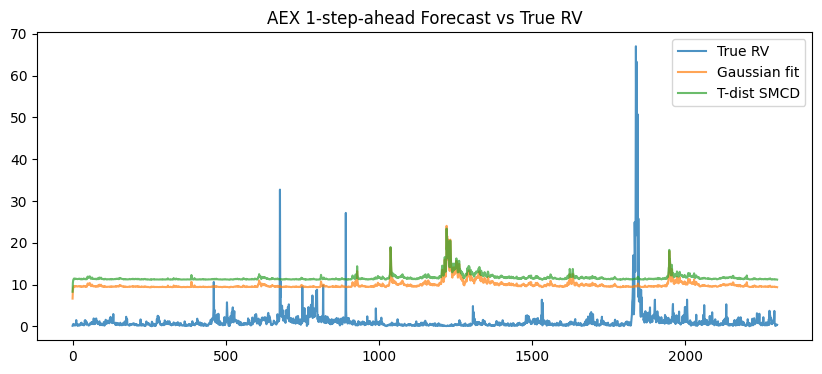

In [ ]:
true_rv   = np.asarray(data_dict['AEX']['train']['rv_test'])  # shape (2302, 1) or similar
true_rv   = true_rv.ravel()                                    # now shape (2302,)
vol_gauss = np.asarray(vol_gauss)                              # shape (2301,)
vol_tdist = np.asarray(vol_tdist)                              # shape (2301,)

# drop the first (in-sample) RV and then take the common length
y_all    = true_rv[1:]          # shape (2301,)
n_common = min(len(y_all), len(vol_gauss), len(vol_tdist))
y        = y_all[:n_common]     # (2301,)
yG       = vol_gauss[:n_common]
yT       = vol_tdist[:n_common]

print("aligned shapes:", y.shape, yG.shape, yT.shape)
assert y.shape == yG.shape == yT.shape

def qlike(y, yhat):
    return np.mean(y/yhat - np.log(y/yhat) - 1)

def corr(y, yhat):
    return np.corrcoef(y, yhat)[0,1]

mse = lambda a,b: np.mean((a-b)**2)
mae = lambda a,b: np.mean(np.abs(a-b))

print(f"Gaussian   → MSE={mse(y,yG):.6f}, MAE={mae(y,yG):.6f}, QLIKE={qlike(y,yG):.6f}, Corr={corr(y,yG):.4f}")
print(f"T-dist SMCD→ MSE={mse(y,yT):.6f}, MAE={mae(y,yT):.6f}, QLIKE={qlike(y,yT):.6f}, Corr={corr(y,yT):.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(y,    label="True RV",     alpha=0.8)
plt.plot(yG,   label="Gaussian fit", alpha=0.7)
plt.plot(yT,   label="T-dist SMCD",  alpha=0.7)
plt.legend()
plt.title("AEX 1-step-ahead Forecast vs True RV")
plt.show()



In [ ]:
# Verify alignment visually for first 10 points
print("True RV | Gaussian | T-dist")
for i in range(10):
    print(f"{y[i]:.6f} | {yG[i]:.6f} | {yT[i]:.6f}")

True RV | Gaussian | T-dist
0.150022 | 6.660875 | 8.303939
0.397400 | 8.515565 | 10.421254
0.518695 | 9.154204 | 11.048586
0.355904 | 9.416604 | 11.264737
0.611262 | 9.571016 | 11.374236
0.316005 | 9.698238 | 11.470386
0.234610 | 9.497568 | 11.288551
0.263337 | 9.548802 | 11.334775
0.264933 | 9.610917 | 11.384387
0.258549 | 9.677825 | 11.436166


In [ ]:
print(f"True RV range: [{y.min():.4f}, {y.max():.4f}]")
print(f"T-dist forecasts range: [{yT.min():.4f}, {yT.max():.4f}]")

True RV range: [0.0359, 67.0362]
T-dist forecasts range: [8.3039, 23.3988]


Text(0.5, 1.0, 'T-dist Residual Plot')

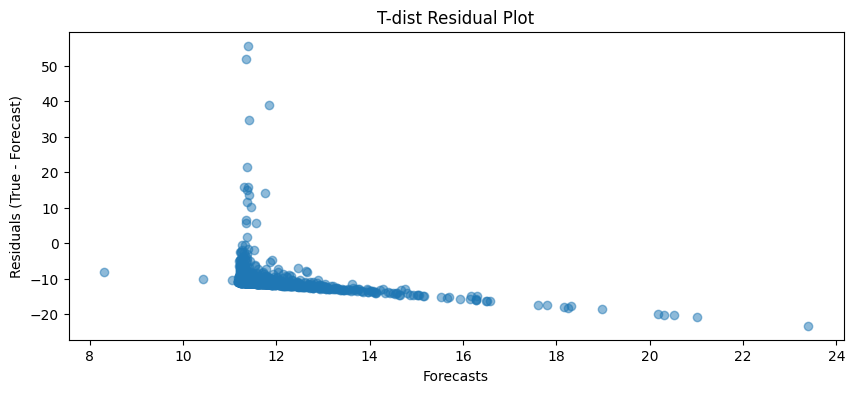

In [ ]:
residuals_t = y - yT
plt.figure(figsize=(10,4))
plt.scatter(yT, residuals_t, alpha=0.5)
plt.xlabel('Forecasts')
plt.ylabel('Residuals (True - Forecast)')
plt.title('T-dist Residual Plot')

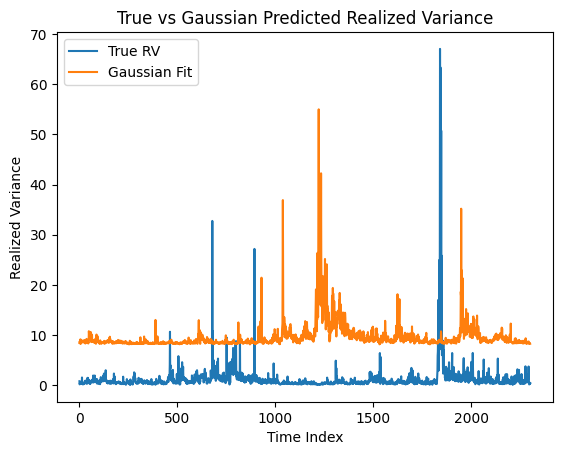

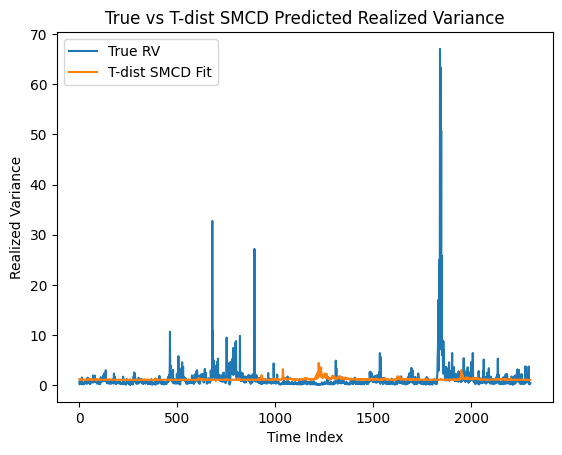

In [ ]:
# 2) Time‐series plots
plt.figure()
plt.plot(true_rv, label='True RV')
plt.plot(vol_gauss, label='Gaussian Fit')
plt.legend()
plt.title('True vs Gaussian Predicted Realized Variance')
plt.xlabel('Time Index')
plt.ylabel('Realized Variance')
plt.show()

plt.figure()
plt.plot(true_rv, label='True RV')
plt.plot(vol_tdist, label='T-dist SMCD Fit')
plt.legend()
plt.title('True vs T-dist SMCD Predicted Realized Variance')
plt.xlabel('Time Index')
plt.ylabel('Realized Variance')
plt.show()

In [ ]:
# second part -> Multi RV
import datetime as dt
from scipy.stats import norm, t
import statsmodels.api as sm
import sys, os
sys.path.append(os.path.abspath("/Users/ananyaparikh/Documents/Coding/DeepRGARCH/DeepRGARCH"))
from rerech import utils as ut
from model import RealRECH_2LSTM, RealRECHD_2LSTM
import distributions as dists

def get_dataset(df,
                rv_cols=None,
                expand_dims=True,
                scale='train',
                st=dt.datetime(2004, 1, 1),
                en=dt.datetime(2022, 1, 1)):
    # choose RV columns & basic cleaning

    if rv_cols is None:
        rv_cols = ['rv5', 'bv', 'medrv', 'rk_parzen', 'rsv']

    df = df.copy()
    df = df.loc[st:en]                              
    # daily close-to-close returns
    df['return'] = np.log(df['close_price']).diff()
    df.dropna(subset=['return'], inplace=True)
    df['return'] = 100 * (df['return'] - df['return'].mean())

    # put realised measures on the same order of magnitude
    df[rv_cols] *= 1e4

    # 2. split train / test  (simple 50-50)
    n_total = len(df)
    n_train = n_total // 2
    df_train = df.iloc[:n_train]
    df_test  = df.iloc[n_train:]

    # 3. scale realised vols so that E[r²] ≈ E[rv]

    if scale == 'train':
        c = (df_train['return'] ** 2).mean() / df_train[rv_cols].mean()
    elif scale == 'all':
        c = (df['return'] ** 2).mean() / df[rv_cols].mean()
    elif scale in ('none', None):
        c = 1.0
    else:
        raise ValueError("scale must be 'train', 'all', or 'none'")
    df[rv_cols] *= c

    # 4. convert to NumPy
    y_train = df_train['return'].to_numpy()
    y_test  = df_test ['return'].to_numpy()
    rv_train = df_train[rv_cols].to_numpy()        
    rv_test  = df_test [rv_cols].to_numpy()        

    if expand_dims:
        y_train = y_train.reshape(-1, 1)
        y_test  = y_test .reshape(-1, 1)

    return {
        'y_train' : y_train,
        'y_test'  : y_test,
        'rv_train': rv_train,
        'rv_test' : rv_test,
        'date'    : df.index
    }


In [ ]:
class IID(dists.ProbDist):
    """
    Product of K independent identical 1-D distributions.
    """
    def __init__(self, base_dist, K):
        self.base = base_dist
        self.K = K
        self.dim = K
        self.dtype = base_dist.dtype

    def rvs(self, size=None):
        return np.column_stack([self.base.rvs(size=size) for _ in range(self.K)])

    def logpdf(self, x):
        return np.sum(self.base.logpdf(x), axis=-1)


In [ ]:
# PRIOR FOR K REALISED-VOL MEASURES

K = 5                               # rv5, bv, medrv, rk_parzen, rsv
multi_rv_prior = dists.StructDist({
    # ----- copy the single-RV scalars unchanged -------------
    'v0f'  : dists.Normal(0, .1),
    'v1f'  : dists.Normal(0, .1),
    'v2f'  : dists.Normal(0, .1),
    'v3f'  : dists.Normal(0, .1),
    'wf'   : dists.Normal(0, .1),
    'bf'   : dists.Normal(0, .1),

    'v0i'  : dists.Normal(0, .1),
    'v1i'  : dists.Normal(0, .1),
    'v2i'  : dists.Normal(0, .1),
    'v3i'  : dists.Normal(0, .1),
    'wi'   : dists.Normal(0, .1),
    'bi'   : dists.Normal(0, .1),

    'v0o'  : dists.Normal(0, .1),
    'v1o'  : dists.Normal(0, .1),
    'v2o'  : dists.Normal(0, .1),
    'v3o'  : dists.Normal(0, .1),
    'wo'   : dists.Normal(0, .1),
    'bo'   : dists.Normal(0, .1),

    'v0d'  : dists.Normal(0, .1),
    'v1d'  : dists.Normal(0, .1),
    'v2d'  : dists.Normal(0, .1),
    'v3d'  : dists.Normal(0, .1),
    'wd'   : dists.Normal(0, .1),
    'bd'   : dists.Normal(0, .1),

    'beta0': dists.TruncatedNormal(0.0, 2.0, -8.0, 8.0),
    'beta1': dists.Gamma(2, 5),
    'beta' : dists.Uniform(0, 1),

    # K-vector parameters
    'gamma'  : dists.IID(dists.Beta(2, 5),     K),
    'xi'     : dists.IID(dists.Gamma(1, 1),    K),
    'phi'    : dists.IID(dists.Gamma(1, 1),    K),
    'tau1'   : dists.IID(dists.Normal(0, .1),  K),
    'tau2'   : dists.IID(dists.Normal(0, .1),  K),
    'sigmau2': dists.IID(dists.Gamma(1, 5),    K),
})



In [ ]:
def multi_rv_cstr(theta):
    # positivity etc. Add whatever extra stationarity rule you want
    check1 = (theta['beta'] >= 0)
    check2 = np.all(theta['gamma'] >= 0, axis=1)
    # Example RealGARCH stability: beta + Σ γᵢ ϕᵢ < 1
    stability = (theta['beta'] + np.sum(theta['gamma'] * theta['phi'], axis=1) < 1)
    return check1 & check2 & stability


In [ ]:
# Assuming data_dict is already loaded as in your other examples
data_dict = ut.build_data_dict(ut.load_rv(filepath='/Users/ananyaparikh/Documents/Coding/DeepRGARCH/code submission/data/rv.pkl'))
tickers = list(data_dict.keys())
model_dict = defaultdict(lambda: {})

# You may need to define a prior for RealRECH_2LSTM if not already defined
# If not defined, you might need to create one similar to realrech_prior
# For example:
# ut.realrech_2lstm_prior = lambda N: {...}  # Define the prior parameters

# Run across all tickers
for ticker in tickers:
    # Get data
    data = data_dict[ticker]['train']
    y_train, y_test, rv_train, rv_test = data['y_train'], data['y_test'], data['rv_train'], data['rv_test']
    
    # Run RealRECH_2LSTM model
    # We'll use the realrech_prior since it's likely compatible (or create a new one if needed)
    realrech_2lstm = mdl.RealRECH_2LSTM(prior=ut.realrech_2lstm_prior, data=[y_train, rv_train])
    realrech_2lstm.run()
    
    # Run RealRECHD_2LSTM model (for prediction/testing)
    model_dict[ticker]['realrech_2lstm'] = mdl.RealRECHD_2LSTM(
        pre=realrech_2lstm, 
        data=[y_train, y_test, rv_train, rv_test]
    )
    model_dict[ticker]['realrech_2lstm'].run()
    
    # Save model to disk
    with open('checkpoint/{}_{}_{}.pkl'.format(ticker, 'realrech_2lstm', 0), 'wb') as f:
        pickle.dump(model_dict[ticker]['realrech_2lstm'], f)
    
    print(f"Completed {ticker}: RealRECH_2LSTM model")